# Goal
Subscriptions are a great business model. There are so many advantages for businesses in having subscribers compared to single purchase users: revenue by customer is much higher, it is possible to cross-sell to the subscribers, future revenue is easily predictable, there is a signiﬁcant cost (time/eﬀort/etc.) for the customer in canceling the subscription, etc. It is no surprise then that so many companies have subscription business models (or try very hard to come up with one!). The goal of this challenge is to model subscription retention rate.


1. A model that predicts monthly retention rate for the diﬀerent subscription price points 
2. Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months? 
3. How do user country and source aﬀect subscription retention rate? How would you use these ﬁndings to improve the company revenue?

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file ='data/subscription.csv'
data =pd.read_csv(file)
data.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


In [10]:
max(data.groupby("user_id").size()) #confirm user_id is unique in this data source

1

In [13]:
data=data.rename( columns={"subscription_signup_date": "SignupDate", "subscription_monthly_cost": "Price"})

In [20]:
data.describe()

,user_id,Price,billing_cycles,is_active
count,500000.000000,500000.000000,500000.000000,500000.000000
mean,250000.500000,48.469620,2.384970,0.099998
std,144337.711635,19.570745,2.254952,0.299998
min,1.000000,29.000000,1.000000,0.000000
25%,125000.750000,29.000000,1.000000,0.000000
50%,250000.500000,49.000000,1.000000,0.000000
75%,375000.250000,49.000000,3.000000,0.000000
max,500000.000000,99.000000,8.000000,1.000000


In [73]:
def retention_rate(df):
    total_num = len(df)
    rate = []
    for i in [1,2,3,4,5,6,7,8]:
        rate.append(len(df[df['billing_cycles'] >= i]) / total_num)
        
    #return pd.Series(rate, index=[1, 2, 3, 4, 5, 6, 7, 8])
    return pd.Series(rate)

# calculate the retention rate for each montly cost
retention = data.groupby('Price').apply(retention_rate)
retention

,0,1,2,3,4,5,6,7
Price,,,,,,,,
29,1.0,0.607542,0.458473,0.376232,0.323028,0.285416,0.257157,0.235901
49,1.0,0.383666,0.206247,0.134043,0.096466,0.074072,0.059408,0.048845
99,1.0,0.158769,0.070040,0.042411,0.029676,0.022182,0.017937,0.015007


In [70]:
d1=data.loc[:,["user_id","Price","billing_cycles"]]

In [71]:
pd.pivot_table(d1,   index=['Price'],columns=['billing_cycles'], aggfunc=np.count_nonzero)
#below pivot is actually showing how many of user did not 

user_id                                              
billing_cycles       1      2      3      4     5     6     7      8
Price                                                               
29               57441  21818  12037   7787  5505  4136  3111  34527
49              185145  53296  21690  11288  6727  4405  3173  14673
99               44788   4724   1471    678   399   226   156    799

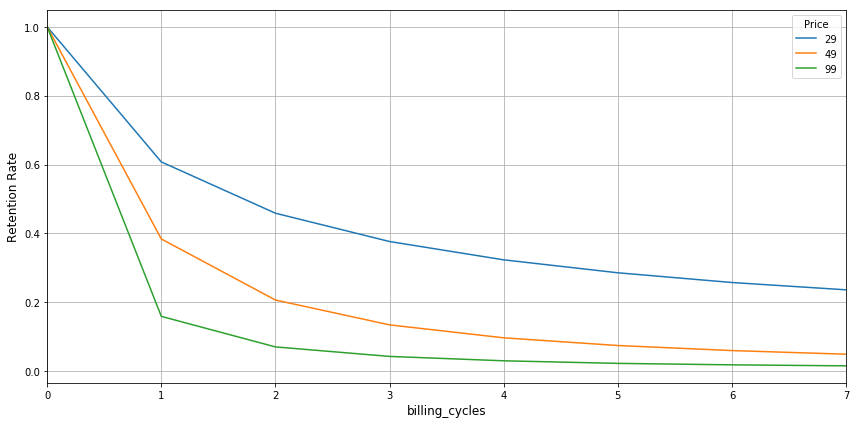

In [78]:

# visualization
fig, ax = plt.subplots(figsize=(12, 6))
retention.T.plot(kind='line', ax=ax)
ax.set_xlabel('billing_cycles', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()


## make linear regression for question 1

In [140]:
#get some features 
x=np.array([1,2,3,4,5,6,7,8])
x2=x**2
logx=np.log(x)

rate29=(retention.loc[29])
rate49=(retention.loc[49])
rate99=(retention.loc[99])

In [141]:
features = pd.DataFrame({'x': x, 'x2': x2, 'logx': logx, 'y_29': rate29, 'y_49': rate49, 'y_99': rate99}, 
                        columns=['x', 'x2', 'logx', 'y_29', 'y_49', 'y_99'])
features

,x,x2,logx,y_29,y_49,y_99
0,1,1,0.000000,1.000000,1.000000,1.000000
1,2,4,0.693147,0.607542,0.383666,0.158769
2,3,9,1.098612,0.458473,0.206247,0.070040
3,4,16,1.386294,0.376232,0.134043,0.042411
4,5,25,1.609438,0.323028,0.096466,0.029676
5,6,36,1.791759,0.285416,0.074072,0.022182
6,7,49,1.945910,0.257157,0.059408,0.017937
7,8,64,2.079442,0.235901,0.048845,0.015007


In [144]:
#fit linear regression model
from sklearn.linear_model import LinearRegression 
model_29 = LinearRegression()
model_49 = LinearRegression()
model_99 = LinearRegression()

model_29 = model_29.fit(features[['x', 'x2', 'logx']], np.log(features['y_29']))
model_49 = model_49.fit(features[['x', 'x2', 'logx']], np.log(features['y_49']))
model_99 = model_99.fit(features[['x', 'x2', 'logx']], np.log(features['y_99']))


## make prediction for question 2

In [145]:
#make prediction
x=np.array([1,2,3,4,5,6,7,8,9,10,11,12])
x2=x**2
logx=np.log(x)

pred = pd.DataFrame({'x': x, 'x2': x2, 'logx': logx}, columns=['x', 'x2', 'logx'])

pred['pred_29'] = np.exp(model_29.predict(pred[['x', 'x2', 'logx']]))
pred['pred_49'] = np.exp(model_49.predict(pred[['x', 'x2', 'logx']]))
pred['pred_99'] = np.exp(model_99.predict(pred[['x', 'x2', 'logx']]))

In [146]:
print(np.exp(1) )
print(np.log(2.718))
print(np.log(np.e))#1
print(np.log10(2.718))
print(np.log2(2.718))
print(np.log1p(2.718)) #1.3131858892992523

2.71828182846
0.999896315729
1.0
0.434249452396
1.44254545611
1.3131858893


In [147]:
def mean_absolute_percentage_error(y_true, y_pred):  
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [156]:
mean_absolute_percentage_error(features.T.loc["y_29"],pred.T.loc["pred_29"])

0.10479559302021346

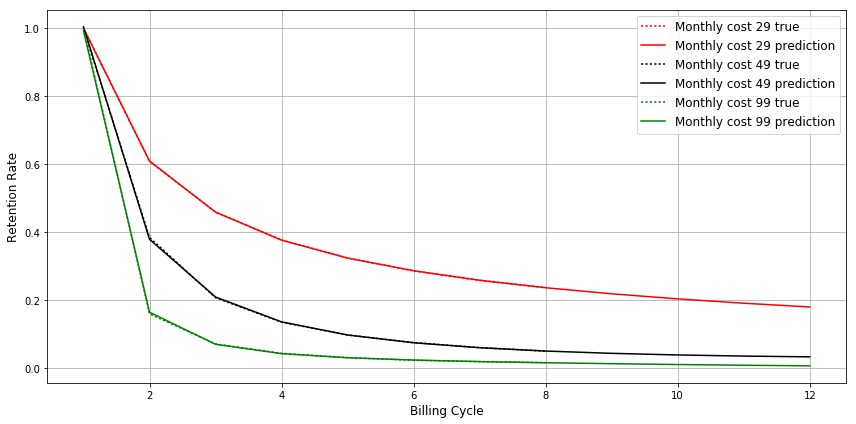

In [166]:
# visualization
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(features['x'], features['y_29'], 'r:', label='Monthly cost 29 true')
ax.plot(pred['x'], pred['pred_29'], 'r-', label='Monthly cost 29 prediction')

ax.plot(features['x'], features['y_49'], 'k:', label='Monthly cost 49 true')
ax.plot(pred['x'], pred['pred_49'], 'k-', label='Monthly cost 49 prediction')
ax.plot(features['x'], features['y_99'], 'g:', label='Monthly cost 99 true')
ax.plot(pred['x'], pred['pred_99'], 'g-', label='Monthly cost 99 prediction')
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()


## check influence on country and source 

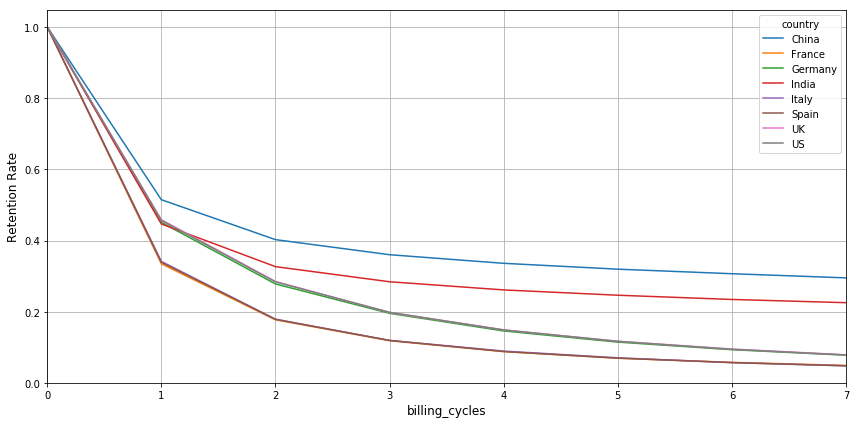

In [168]:
retention_country = data.groupby('country').apply(retention_rate)

# visualization
fig, ax = plt.subplots(figsize=(12, 6))
retention_country.T.plot(kind='line', ax=ax)
ax.set_xlabel('billing_cycles', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()


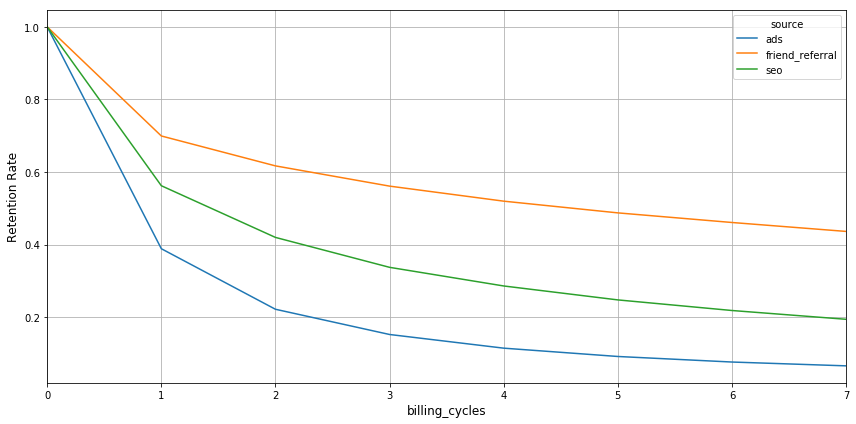

In [169]:
retention_source = data.groupby('source').apply(retention_rate)

# visualization
fig, ax = plt.subplots(figsize=(12, 6))
retention_source.T.plot(kind='line', ax=ax)
ax.set_xlabel('billing_cycles', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()
